In [1]:
from typing import Union, List, Dict, Tuple, Callable

import os
import pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import json
import pickle

import sys
sys.path.append("..")

import tqdm

import numpy as np
import pandas as pd

from scipy.stats import chi2_contingency

import tensorflow as tf
from pytorch_transformers import RobertaTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from src.eqt.datasets import create_test_dataset_for_prediction
from src.eqt.preprocess_data import preprocess_data
from src.eqt.model_qbert import QBERT
from src.eqt.model_utils import create_masks


mappings = {
    'type': {
        'Ask about antecedent':  0,
        'Ask about consequence': 1,
        'Ask for confirmation':  2,
        'Irony':                 3,
        'Negative rhetoric':     4,
        'Positive rhetoric':     5,
        'Request information':   6,
        'Suggest a reason':      7,
        'Suggest a solution':    8,
    },
    'intent': {
        'Amplify excitement': 0,
        'Amplify joy':        1,
        'Amplify pride':      2,
        'De-escalate':        3,
        'Express concern':    4,
        'Express interest':   5,
        'Moralize speaker':   6,
        'Motivate':           7,
        'Offer relief':       8,
        'Pass judgement':     9,
        'Support':           10,
        'Sympathize':        11,
    }
}

class_type = "type"
peak_lr = 2e-5
checkpoints_path = f"../models/{class_type}"
data_path = "../data/eqt/quest_df_all_labelled_intents.pickle"
restore_epoch = 3 if class_type == "intent" else 4

In [2]:
# Load model checkpoint
num_layers         = 12
d_model            = 768
num_heads          = 12
dff                = d_model * 4
hidden_act         = "gelu"
dropout_rate       = 0.1
layer_norm_eps     = 1e-5
max_position_embed = 514

tokenizer  = RobertaTokenizer.from_pretrained("roberta-base")
vocab_size = tokenizer.vocab_size

lab_mapping  = mappings[class_type]
pred_mapping = {v: k for k, v in lab_mapping.items()}
num_classes  = len(pred_mapping.keys())

adam_beta_1  = 0.9
adam_beta_2  = 0.98
adam_epsilon = 1e-6

qbert = QBERT(num_layers, 
              d_model, 
              num_heads, 
              dff, 
              hidden_act, 
              dropout_rate,
              layer_norm_eps, 
              max_position_embed, 
              vocab_size, 
              num_classes)
optimizer = tf.keras.optimizers.legacy.Adam(peak_lr, 
                                            beta_1=adam_beta_1, 
                                            beta_2=adam_beta_2,
                                            epsilon=adam_epsilon)
ckpt = tf.train.Checkpoint(model=qbert, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoints_path, max_to_keep=None)
ckpt.restore(ckpt_manager.checkpoints[restore_epoch - 1]).expect_partial()
print('Checkpoint {} restored!!!'.format(ckpt_manager.checkpoints[restore_epoch - 1]))

Checkpoint ../models/type/ckpt-4 restored!!!


In [3]:
def get_label_source(row, class_tag):
    if row[class_tag] != '':
        return row['label_source']
    return 'QBERT'


def predict(test_dataset):
    
    y_pred = []
    pred_ids = []
    for inputs in tqdm.tqdm(test_dataset):
        inp, weights, ids = inputs
        enc_padding_mask = create_masks(inp)
        pred_class = qbert(inp, weights, False, enc_padding_mask)
        pred_class = np.argmax(pred_class.numpy(), axis=1)
        y_pred += pred_class.tolist()
        y_pred_lab = [pred_mapping[pred] for pred in y_pred]
        pred_labels = np.array(y_pred_lab)
        pred_ids += [idx.decode('utf-8') for idx in ids.numpy()]

    return pred_labels, pred_ids

```
# Load dataset
with open(data_path, 'rb') as f:
    quest_df = pickle.load(f)
    quest_df['{}_source'.format(class_type)] = ''
    quest_df['{}_source'.format(class_type)] = quest_df.apply(get_label_source, axis=1, class_tag=class_type)

data = preprocess_data(data_path, class_type, drop_test=False)
test_dataset = create_test_dataset_for_prediction(tokenizer, data, 32, 256, lab_mapping)
predictions, ids = predict(test_dataset)
```

## __Eval Self-chat Dialogues__

### __Dialogue Preprocessing__

We need to truncate dialogues in terms of both __turns__ and __questions__. Each turn will be separated by a newline character. This is how the EQT `create_test_dataset_for_prediction()` function identifies dialogue turns. Further, since the bot may ask more than one questions in each turn, we need to truncate the dialogues multiple times to have the input dialogue end with each question.

In [4]:
def format_dialogue(
        dialogue: List[Dict[str, str]], 
        sep_char: str = "\n",
        key_content: str = "text"
    ) -> str:
    """Simply concatenate the utterances of dialogue turns with a 
        `sep` character, which defaults to the newline character 
        to conform the EQT provided API."""
    
    ret = sep_char.join(d[key_content] for d in dialogue)
    return ret


def generate_samples_from_dialogue(
        dialogue: List[Dict[str, str]],
        q_predictor: Callable[[str], bool] = None,
        key_content: str = "text",
        key_role: str = "role",
        role_bot: str = "therapist",
    ) -> List[str]:

    from nltk.tokenize import sent_tokenize
    
    q_predictor = q_predictor or (lambda x: x.endswith("?"))

    ret = []
    for i, d in enumerate(dialogue, start=1):
        if d[key_role] == role_bot:
            dialogue_truncated = dialogue[:i]

            # Generate one sample for each question in 
            #   the bot's utterance
            sentences_bot = sent_tokenize(d[key_content])
            for j, s in enumerate(sentences_bot, start=1):
                if q_predictor(s):
                    d_cp = d.copy()
                    d_cp[key_content] = " ".join(sentences_bot[:j])
                    sample = dialogue_truncated[:-1] + [d_cp]
                    ret.append(format_dialogue(sample, key_content=key_content))
    return ret

In [5]:
path_dial_penalty = "../data/conversations/hackathon-4turn-8dial-w-penalty.json"
path_dial_default = "../data/conversations/hackathon-4turn-8dial-no-penalty.json"

with open(path_dial_penalty, "r") as f:
    data_penalty = json.load(f)
    dialogues_penalty = [d["dialogue"] for d in data_penalty]

with open(path_dial_default, "r") as f:
    data_default = json.load(f)
    dialogues_default = [d["dialogue"] for d in data_default]

In [6]:
samples_penalty = [generate_samples_from_dialogue(d) for d in dialogues_penalty]
samples_penalty = [s for ss in samples_penalty for s in ss]
samples_penalty = pd.DataFrame({'utterance_truncated': samples_penalty})
samples_penalty["id"] = samples_penalty.index.map(lambda i: f'penalty-{i}')

samples_default = [generate_samples_from_dialogue(d) for d in dialogues_default]
samples_default = [s for ss in samples_default for s in ss]
samples_default = pd.DataFrame({'utterance_truncated': samples_default})
samples_default["id"] = samples_default.index.map(lambda i: f'default-{i}')

samples = pd.concat([samples_penalty, samples_default], axis=0)
samples.head()

,utterance_truncated,id
0,"Hi Hal, I'm feeling really overwhelmed right n...",penalty-0
1,"Hi Hal, I'm feeling really overwhelmed right n...",penalty-1
2,"Hi Hal, I'm feeling really overwhelmed right n...",penalty-2
3,"Hi Hal, I'm feeling really overwhelmed right n...",penalty-3
4,"Hi Hal, I'm feeling really overwhelmed right n...",penalty-4


In [7]:
test_dataset = create_test_dataset_for_prediction(tokenizer, samples, 32, 256, lab_mapping)
predictions, ids = predict(test_dataset)

Vocabulary size is 50265.


100%|██████████| 798/798 [00:00<00:00, 950.41it/s]


Created dataset with 798 examples.


100%|██████████| 25/25 [00:17<00:00,  1.46it/s]


In [8]:
df_pred = pd.DataFrame({'id': ids, f'{class_type}_prediction': predictions})
df_pred = pd.merge(df_pred, samples, on='id', how='left')
df_pred["set_id"] = df_pred["id"].map(lambda x: x.split("-")[0])
df_pred.head()

,id,type_prediction,utterance_truncated,set_id
0,penalty-0,Request information,"Hi Hal, I'm feeling really overwhelmed right n...",penalty
1,penalty-1,Suggest a solution,"Hi Hal, I'm feeling really overwhelmed right n...",penalty
2,penalty-2,Suggest a solution,"Hi Hal, I'm feeling really overwhelmed right n...",penalty
3,penalty-3,Request information,"Hi Hal, I'm feeling really overwhelmed right n...",penalty
4,penalty-4,Request information,"Hi Hal, I'm feeling really overwhelmed right n...",penalty


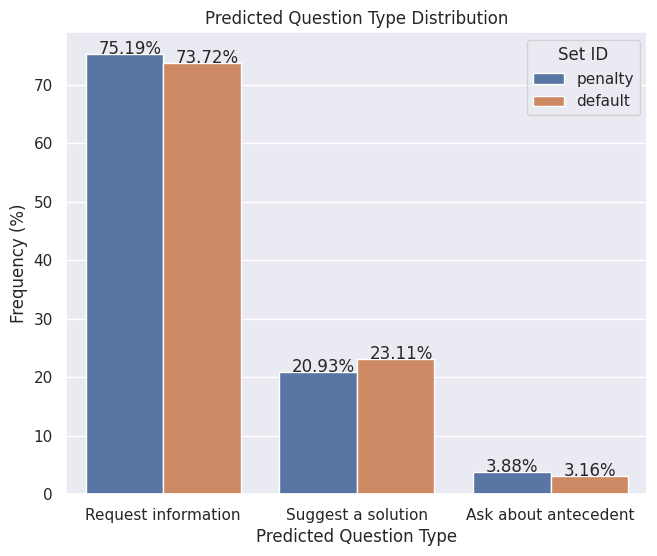

In [9]:
# Plot the distribution (frequency) of question 
#   types by `set_id`
df_vis = df_pred.groupby(["set_id"])[f"{class_type}_prediction"] \
                .value_counts(normalize=True) \
                .rename("percentage") \
                .mul(100) \
                .reset_index() \
                .sort_values(["set_id", "percentage"], ascending=False)

fig, ax = plt.subplots(figsize=(2.5 * df_vis[f"{class_type}_prediction"].nunique(), 6))
sns.barplot(x=f"{class_type}_prediction", 
            y="percentage", 
            hue="set_id", 
            data=df_vis, 
            ax=ax)

ax.set_title(f"Predicted Question {class_type.title()} Distribution")
ax.set_xlabel(f"Predicted Question {class_type.title()}")
ax.set_ylabel("Frequency (%)")
ax.legend(title="Set ID")

for p in ax.patches:
    ax.text(x=p.get_x() + p.get_width() / 6, 
            y=p.get_height(), 
            s=f'{p.get_height().round(2)}%')

In [12]:
# Chi-square test to compare the distribution of
#   question types between the two sets
df_chisq = df_pred.loc[df_pred[f"{class_type}_prediction"].map(lambda s: not s in {"Express interest", "Request information"})] \
                  .groupby(["set_id"])[f"{class_type}_prediction"] \
                  .value_counts() \
                  .rename("count") \
                  .reset_index() \
                  .pivot(index="set_id", columns=f"{class_type}_prediction", values="count")
df_chisq

type_prediction,Ask about antecedent,Request information,Suggest a solution
set_id,,,
default,13,303,95
penalty,15,291,81


In [13]:
# Perform chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(df_chisq.values)

# Print the results
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 0.7778167860921223
P-value: 0.6777963580298305
Degrees of freedom: 2
Expected frequencies: [[ 14.42105263 305.93233083  90.64661654]
 [ 13.57894737 288.06766917  85.35338346]]
